<a href="https://colab.research.google.com/github/VMBoehm/DeNoPa/blob/master/TrainNVP_and_measure_Reconstruction_Noise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import os
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib import rcParams
import sys
import pickle
 
plt.rcParams.update({'font.family' : 'lmodern', 'font.size': 16,                                                                                                                                                    
                     'axes.labelsize': 16, 'legend.fontsize': 12, 
                     'xtick.labelsize': 16, 'ytick.labelsize': 16, 'axes.titlesize': 16,
                     'axes.linewidth': 1.5}) 

In [2]:
import tensorflow as tf
import tensorflow_probability as tfp
import tensorflow_hub as hub
tfd = tfp.distributions
tfb = tfp.bijectors

In [3]:
sys.path.append('../')
from vae.model import get_prior, get_posterior, get_likelihood

In [4]:
import vae.create_datasets as crd

W1031 08:17:31.489459 140459735263040 lazy_loader.py:50] 
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



In [5]:
data_sets  = ['mnist','fmnist']

In [6]:
likelihood  = 'Gauss'
class_label = -1
network_type= 'fully_connected'
latent_size = 8
AE          = False

In [7]:
params={}
module_dirs={}
for data_set in data_sets:
    if AE:
        param = pickle.load(open('../params/params_%s_%s_%d_%d_%s-AE.pkl'%(data_set,likelihood,class_label,latent_size, network_type),'rb'))
    else:
        param = pickle.load(open('../params/params_%s_%s_%d_%d_%s.pkl'%(data_set,likelihood,class_label,latent_size,network_type),'rb'))
    module_dirs[data_set]= param['module_dir']
    params[data_set]=param

In [8]:
generator_path ={}
encoder_path   ={} 
for jj,dataset in enumerate(data_sets):
    module_dir       = os.path.join(module_dirs[dataset],'vae')
    all_subdirs      = [os.path.join(module_dir,d) for d in os.listdir(module_dir+'/') if os.path.isdir(os.path.join(module_dir,d))]
    latest_subdir    = max(all_subdirs, key=os.path.getmtime)
    generator_path[dataset] = os.path.join(latest_subdir,'decoder')
    encoder_path[dataset]   = os.path.join(latest_subdir,'encoder')

In [9]:
print(encoder_path)

{'mnist': '/home/nessa/Documents/codes/vae/modules/mnist/Gauss/class-1/latent_size8/net_type_fully_connected/vae/1571979950/encoder', 'fmnist': '/home/nessa/Documents/codes/vae/modules/fmnist/Gauss/class-1/latent_size8/net_type_fully_connected/vae/1571995072/encoder'}


In [10]:
train_input_fn ={}
eval_input_fn  ={}
batch_size     = 512
for dataset in data_sets:
    param = params[dataset]
    train_input_fn[dataset], eval_input_fn[dataset] = crd.build_input_fns(param['data_dir'],param['data_set'],1,label=param['class_label'],flatten=True)


loading mnist dataset
loading fmnist dataset


In [30]:
tf.reset_default_graph()

lr            = tf.placeholder_with_default(0.001,shape=[])
sigma1        = tf.placeholder_with_default(0.11,shape=[])
sigma2        = tf.placeholder_with_default(0.1,shape=[])
sample_size   = tf.placeholder_with_default(1024,shape=[])

data1test     = eval_input_fn['mnist']()
data2test     = eval_input_fn['fmnist']()
data1train    = train_input_fn['mnist']()
data2train    = train_input_fn['fmnist']()
encoder1      = hub.Module(encoder_path['mnist'], trainable=False)
encoder2      = hub.Module(encoder_path['fmnist'], trainable=False)
generator1    = hub.Module(generator_path['mnist'], trainable=False)
generator2    = hub.Module(generator_path['fmnist'], trainable=False)

prior         = get_prior(params['mnist']['latent_size'])
prior_sample  = prior.sample(sample_size)
prior_sample_small = prior.sample(8)


likelihood1   = get_likelihood(generator1,params['mnist']['likelihood'],sigma1)
likelihood2   = get_likelihood(generator2,params['mnist']['likelihood'],sigma2)

def get_reconstruction(encoder, generator, x):
    encoded,var = tf.split(encoder({'x':x},as_dict=True)['z'], 2, axis=-1)
    recon       = generator({'z':encoded},as_dict=True)['x']
    return recon
    
def get_posterior(likelihood, prior):
    def posterior(z,x):
        return -(likelihood(z).log_prob(x)+prior.log_prob(z))
    return posterior

recon1         = get_reconstruction(encoder2,generator2,data1test)
recon2         = get_reconstruction(encoder1,generator1,data2test)

prob11         = tf.reduce_mean(likelihood1(prior_sample).log_prob(data1test))
prob12         = tf.reduce_mean(likelihood1(prior_sample).log_prob(data2test))

prob21         = tf.reduce_mean(likelihood2(prior_sample).log_prob(data1test))
prob22         = tf.reduce_mean(likelihood2(prior_sample).log_prob(data2test))

prob11_        = tf.reduce_mean(likelihood1(prior_sample).log_prob(data1train))
prob12_        = tf.reduce_mean(likelihood1(prior_sample).log_prob(data2train))

prob21_        = tf.reduce_mean(likelihood2(prior_sample).log_prob(data1train))
prob22_        = tf.reduce_mean(likelihood2(prior_sample).log_prob(data2train))

x_samples1     = likelihood1(prior_sample_small).mean()
x_samples2     = likelihood2(prior_sample_small).mean()


mean Tensor("module_2_apply_default_1/model/decoder/dense_4/BiasAdd:0", shape=(?, 784), dtype=float32)
mean Tensor("module_2_apply_default_2/model/decoder/dense_4/BiasAdd:0", shape=(?, 784), dtype=float32)
mean Tensor("module_3_apply_default_1/model/decoder/dense_4/BiasAdd:0", shape=(?, 784), dtype=float32)
mean Tensor("module_3_apply_default_2/model/decoder/dense_4/BiasAdd:0", shape=(?, 784), dtype=float32)
mean Tensor("module_2_apply_default_3/model/decoder/dense_4/BiasAdd:0", shape=(?, 784), dtype=float32)
mean Tensor("module_2_apply_default_4/model/decoder/dense_4/BiasAdd:0", shape=(?, 784), dtype=float32)
mean Tensor("module_3_apply_default_3/model/decoder/dense_4/BiasAdd:0", shape=(?, 784), dtype=float32)
mean Tensor("module_3_apply_default_4/model/decoder/dense_4/BiasAdd:0", shape=(?, 784), dtype=float32)
mean Tensor("module_2_apply_default_5/model/decoder/dense_4/BiasAdd:0", shape=(8, 784), dtype=float32)
mean Tensor("module_3_apply_default_5/model/decoder/dense_4/BiasAdd:0", s

In [31]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

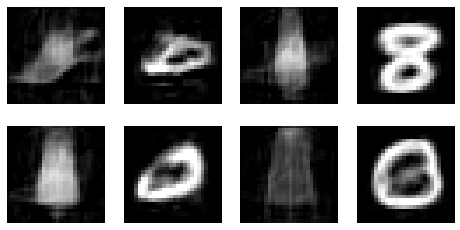

In [36]:
jj=1
plt.figure(figsize=(4*2,2*2))
for ii in range(4):
    rec1, rec2 = sess.run([recon1,recon2])
    plt.subplot(2,4,jj)
    plt.imshow(rec1.reshape(28,28),cmap='gray',vmin=0, vmax=1)
    plt.axis('off')
    jj+=1
    plt.subplot(2,4,jj)
    plt.imshow(rec2.reshape(28,28),cmap='gray',vmin=0, vmax=1)
    plt.axis('off')
    jj+=1

In [25]:
p11, p12, p21, p22 = [], [], [], []
p11t, p12t, p21t, p22t = [], [], [], []
for ii in range(2048):
    p11_, p12_, p21_, p22_= sess.run([prob11, prob12, prob21, prob22], feed_dict={sample_size:4096})
    p11+=[p11_]
    p12+=[p12_]
    p21+=[p21_]
    p22+=[p22_]
    p11t_, p12t_, p21t_, p22t_= sess.run([prob11_, prob12_, prob21_, prob22_], feed_dict={sample_size:4096})
    p11t+=[p11t_]
    p12t+=[p12t_]
    p21t+=[p21t_]
    p22t+=[p22t_]

In [26]:
np.asarray(p11).shape

(2048,)

Text(0.5, 0, 'log p(x)')

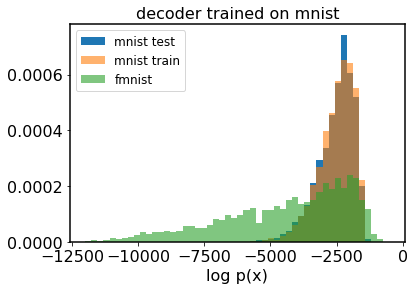

In [27]:
#decoder trained on mnist
plt.title('decoder trained on mnist')
_, bins, _=plt.hist(p11, label='mnist test',density=True, range=(-12000,-500), bins=50)
_=plt.hist(p11t, alpha=0.6,label='mnist train', density=True, bins=bins)
_=plt.hist(p12, alpha=0.6,label='fmnist', density=True, bins=bins)
plt.legend()
plt.xlabel('log p(x)')

Text(0.5, 0, 'log p(x)')

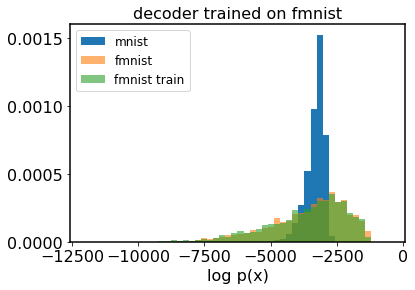

In [28]:
#decoder trained on mnist
plt.title('decoder trained on fmnist')
_, bins, _=plt.hist(p21, label='mnist',density=True, range=(-12000,-500), bins=50)
_=plt.hist(p22, alpha=0.6,label='fmnist', density=True, bins=bins)
_=plt.hist(p22t, alpha=0.6,label='fmnist train', density=True, bins=bins)
plt.legend()
plt.xlabel('log p(x)')

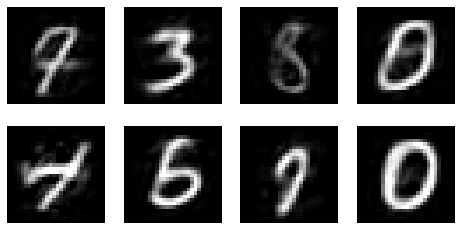

In [18]:
x_sample=sess.run(x_samples1)
jj=1
plt.figure(figsize=(4*2,2*2))
for ii in range(8):
    plt.subplot(2,4,jj)
    plt.imshow(x_sample[ii].reshape(28,28),cmap='gray',vmin=0, vmax=1)
    plt.axis('off')
    jj+=1

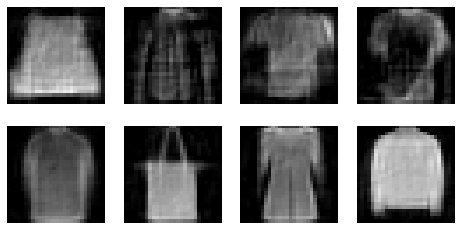

In [19]:
x_sample=sess.run(x_samples2)
jj=1
plt.figure(figsize=(4*2,2*2))
for ii in range(8):
    plt.subplot(2,4,jj)
    plt.imshow(x_sample[ii].reshape(28,28),cmap='gray',vmin=0, vmax=1)
    plt.axis('off')
    jj+=1